In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load COVID-19 New Cases Detection Data and Plot to See the Trend

In [2]:
covid = pd.read_csv("~/Desktop/GU/ANLY 560/project_source-git/data/COVID/owid-covid-data.csv")
covid = covid[covid['iso_code']=='USA']
us_new = covid[['date','new_cases']]
us_new['date'] = pd.to_datetime(us_new['date'])
us_new['new_cases'] = us_new['new_cases'].fillna(0)
us_new['new_cases'] = us_new['new_cases'].astype('int')


/var/folders/xd/4f5_m4xx5qxgyt9ryqlq_b400000gn/T/ipykernel_20356/2605105349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_new['date'] = pd.to_datetime(us_new['date'])
/var/folders/xd/4f5_m4xx5qxgyt9ryqlq_b400000gn/T/ipykernel_20356/2605105349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_new['new_cases'] = us_new['new_cases'].fillna(0)
/var/folders/xd/4f5_m4xx5qxgyt9ryqlq_b400000gn/T/ipykernel_20356/2605105349.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

#### Split into Train, Validation and Test Datasets

In [3]:
train = pd.DataFrame(us_new['new_cases'][us_new['date']<'2023-01-01'])
validate = pd.DataFrame(us_new['new_cases'][(us_new['date']>='2022-09-01')& (us_new['date']<'2023-01-01')])
test = pd.DataFrame(us_new['new_cases'][us_new['date']>='2023-01-01'])

#### See Train and Test Datasets in a Plot

Text(0.5, 1.0, 'Time-Series for Covid New Cases Detection during 2020 to 2023')

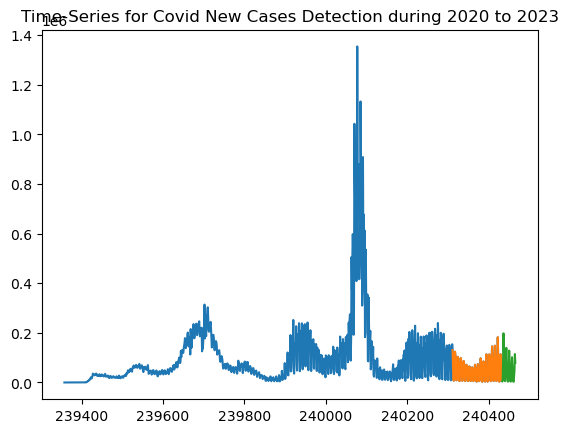

In [4]:
plt.figure()
train['new_cases'].plot(label='train')
validate['new_cases'].plot(label='validate')
test['new_cases'].plot(label='test')
plt.title('Time-Series for Covid New Cases Detection during 2020 to 2023')

#### Create Univariate Case Sequence

In [5]:
def sampling(sequence, n_steps):
    X,Y = list(),list()
    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x,y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

In [6]:
n_steps = 5
X, Y = sampling(train['new_cases'].tolist(),n_steps)
X_val, Y_val = sampling(validate['new_cases'].tolist(),n_steps)
X_test, Y_test = sampling(test['new_cases'].tolist(),n_steps)

In [7]:
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, GRU, SimpleRNN, Dense
from keras.optimizers import RMSprop
from tensorflow.keras import optimizers, regularizers

2023-04-29 11:01:55.514620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def plot_history(metric="loss",skip=0): 
    history_dict = history.history
    loss_values = history_dict[metric]
    val_loss_values = history_dict["val_"+metric]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs[skip:], loss_values[skip:], "bo", label="Training "+metric)
    plt.plot(epochs[skip:], val_loss_values[skip:], "b", label="Validation "+metric)
    plt.title("Training and validation "+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

## Build a RNN Model for Predicting New Cases

In [9]:
def simple_RNN():
    model = Sequential()
    model.add(SimpleRNN(256,input_shape=(n_steps,1)))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.RMSprop(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),'accuracy']) 
    model.summary()
    return model

In [10]:
model = simple_RNN()
X = X.reshape(X.shape[0],X.shape[1],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)
history = model.fit(X,Y,epochs=500,validation_split=0.2,verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)                 3

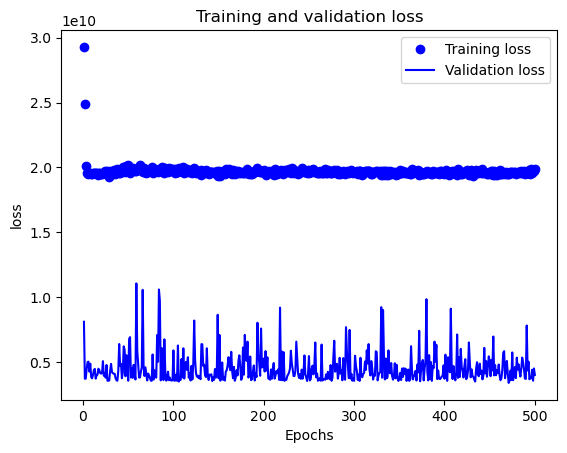

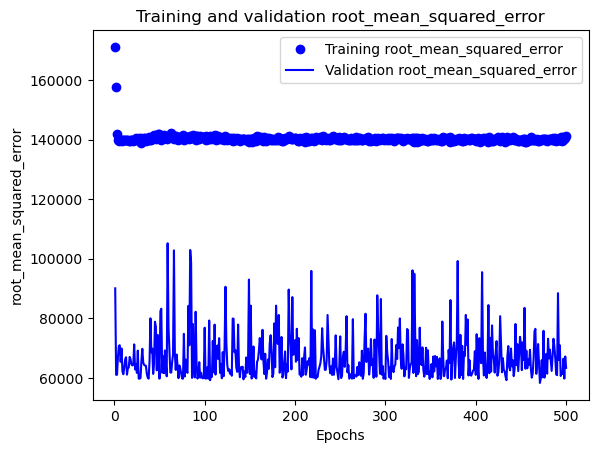

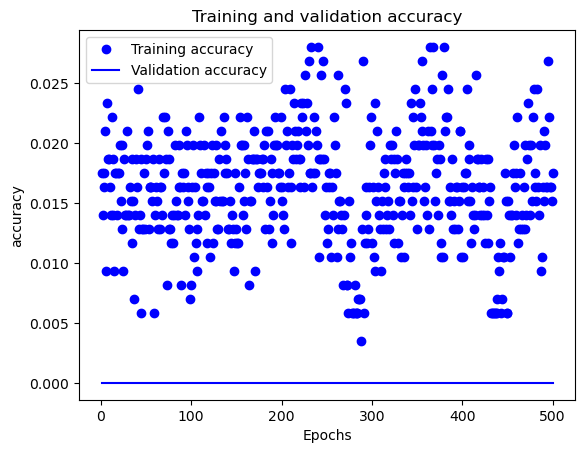

In [11]:
plot_history("loss")
plot_history("root_mean_squared_error")
plot_history("accuracy")
history_dict = history.history
RMSE_values = np.mean(history_dict["root_mean_squared_error"])
val_RMSE_values = np.mean(history_dict["val_root_mean_squared_error"])
accuracy_values = np.mean(history_dict['accuracy'])
val_accuracy_values = np.mean(history_dict['val_accuracy'])

In [12]:
ypred = model.predict(X_test)
ypred = ypred

1/1 [==============================] - 0s 156ms/step


## Build a LSTM Model for Predicting New Cases

In [13]:
def LSTM_model():
    model = Sequential() 
    model.add(tf.keras.layers.LSTM(256,input_shape=(n_steps,1)))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),'accuracy']) 
    model.summary()
    return model

In [14]:
model2=LSTM_model()
history = model2.fit(X,Y,epochs=500,validation_split=0.2,verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 4)                

2023-04-29 11:03:38.979444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 11:03:38.981038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 11:03:38.982039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

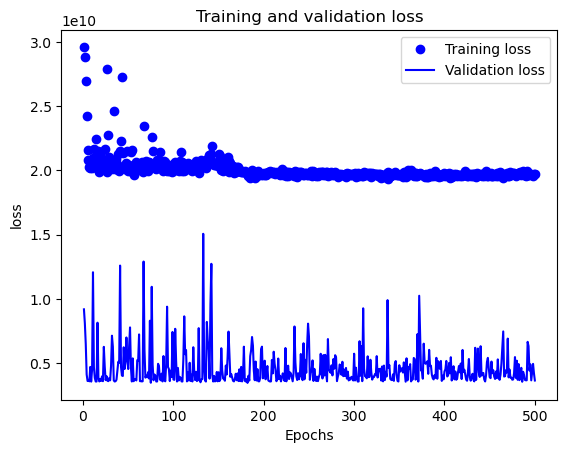

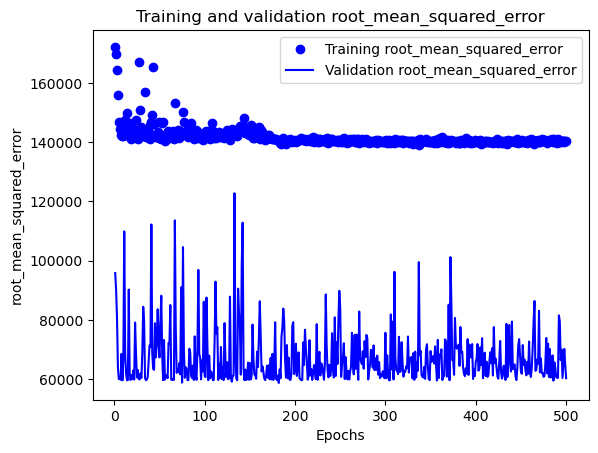

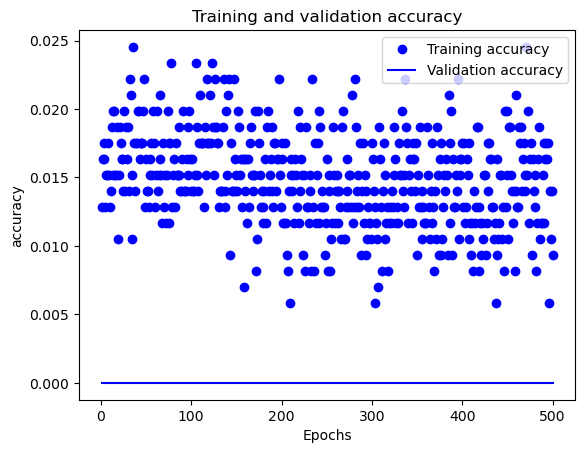

In [15]:
plot_history("loss")
plot_history("root_mean_squared_error")
plot_history("accuracy")
history_dict = history.history
RMSE_values2 = np.mean(history_dict["root_mean_squared_error"])
val_RMSE_values2 = np.mean(history_dict["val_root_mean_squared_error"])
accuracy_values2 = np.mean(history_dict['accuracy'])
val_accuracy_values2 = np.mean(history_dict['val_accuracy'])

In [16]:
ypred2 = model2.predict(X_test)
ypred2 = ypred2

1/1 [==============================] - 0s 343ms/step


2023-04-29 11:07:48.651511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 11:07:48.653885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 11:07:48.655417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Build a GRU Model for Predicting New Cases

In [17]:
def GRU_model():
    model = Sequential() 
    model.add(GRU(256,input_shape=(n_steps,1))) 
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.RMSprop(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),'accuracy']) 
    model.summary()
    return model

In [18]:
model3=GRU_model()
history = model3.fit(X,Y,epochs=500,validation_split=0.2,verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               198912    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 4)                

2023-04-29 11:07:49.044728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 11:07:49.046530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 11:07:49.047428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

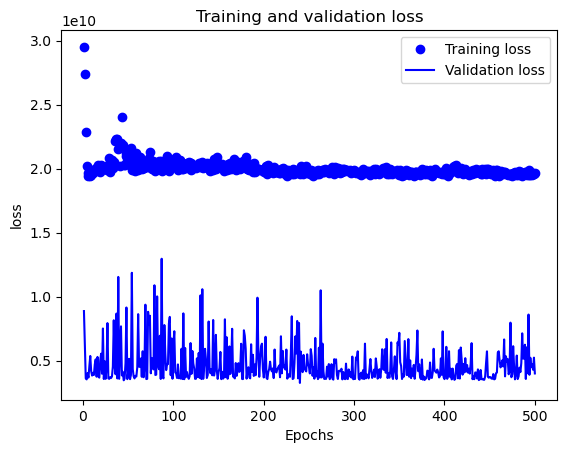

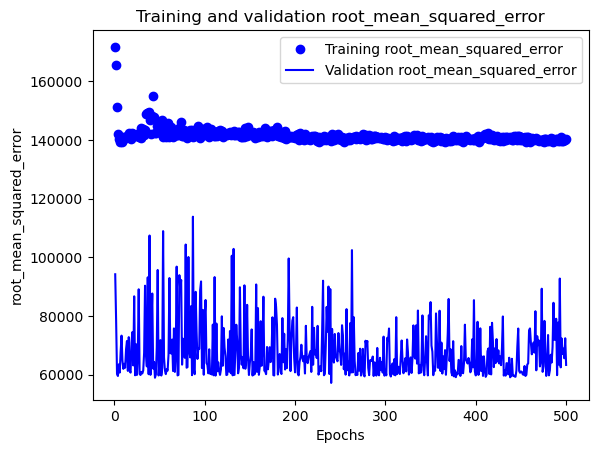

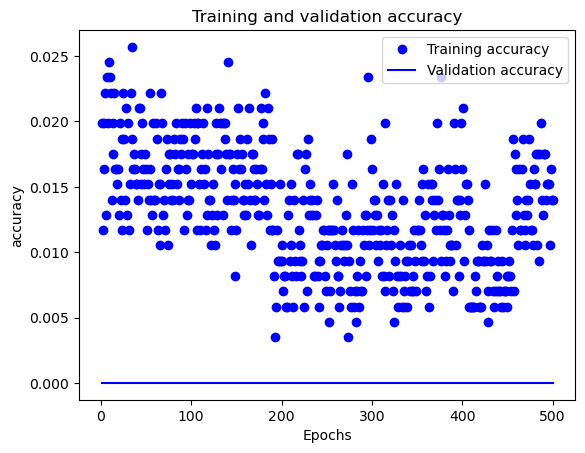

In [19]:
plot_history("loss")
plot_history("root_mean_squared_error")
plot_history("accuracy")
history_dict = history.history
RMSE_values3 = np.mean(history_dict["root_mean_squared_error"])
val_RMSE_values3 = np.mean(history_dict["val_root_mean_squared_error"])
accuracy_values3 = np.mean(history_dict['accuracy'])
val_accuracy_values3 = np.mean(history_dict['val_accuracy'])

In [20]:
ypred3 = model3.predict(X_test)

1/1 [==============================] - 0s 290ms/step


2023-04-29 11:11:08.895558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 11:11:08.896432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 11:11:08.897835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Compare Prediction with Actural

Text(0.5, 1.0, 'Actual vs. Prediction for 3 Deep Learning Methods')

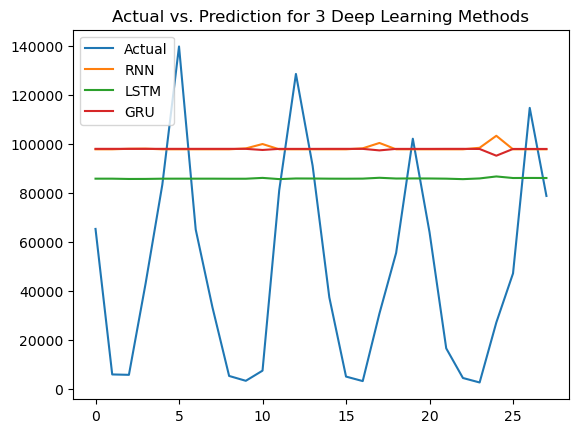

In [21]:
plt.figure()
results = pd.DataFrame()
results['actual'] = Y_test
results['RNN'] = ypred
results['LSTM'] = ypred2
results['GRU'] = ypred3
results['actual'].plot(label='Actual')
results['RNN'].plot(label='RNN')
results['LSTM'].plot(label='LSTM')
results['GRU'].plot(label='GRU')
#ypred2[0].plot(label='LSTM')
#ypred3[0].plot(label='GRU')
plt.legend()
plt.title('Actual vs. Prediction for 3 Deep Learning Methods')

In [22]:
evaluation = pd.DataFrame()
evaluation['RNN'] = RMSE_values,val_RMSE_values,accuracy_values
evaluation['LSTM'] = RMSE_values2,val_RMSE_values2,accuracy_values2
evaluation['GRU'] = RMSE_values3,val_RMSE_values3,accuracy_values3
evaluation

,RNN,LSTM,GRU
0,140309.938938,141674.997000,141472.424781
1,66965.486039,67345.735477,68069.000531
2,0.016136,0.014871,0.013126


## Build a RNN Model with Regularizations

In [23]:
def RNN2():
    model = Sequential()
    model.add(SimpleRNN(256,input_shape=(n_steps,1),dropout=0.2, recurrent_dropout=0.8))
    model.add(Dense(128,kernel_regularizer=regularizers.L1(l1=1e-5)))#))
    model.add(Dense(64))#,bias_regularizer=regularizers.L2(1e-4)))
    model.add(Dense(32))#,activity_regularizer=regularizers.L2(1e-4)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(optimizer=optimizers.RMSprop(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),'accuracy']) 
    model.summary()
    return model

In [24]:
model4=RNN2()
history = model4.fit(X,Y,epochs=500,validation_split=0.2,verbose=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 4)                

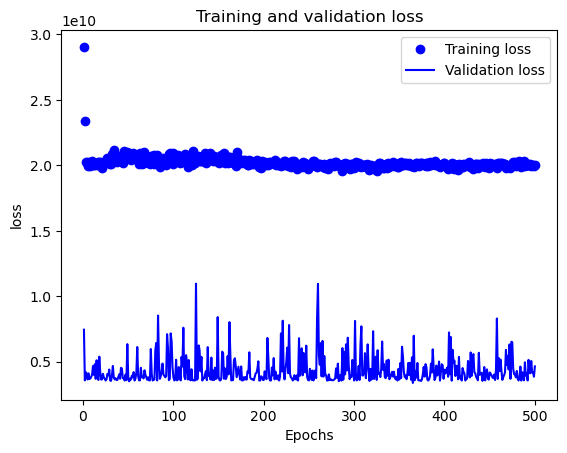

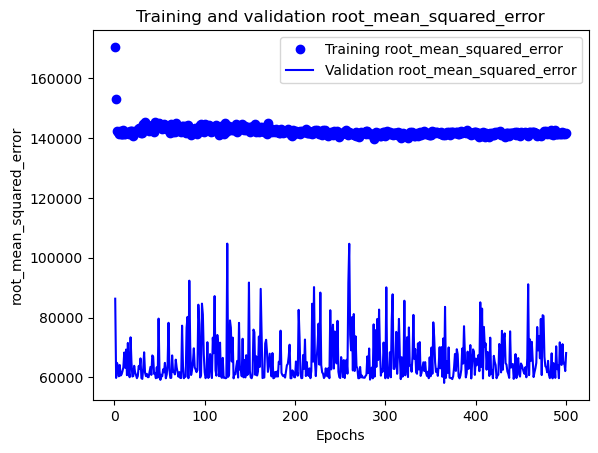

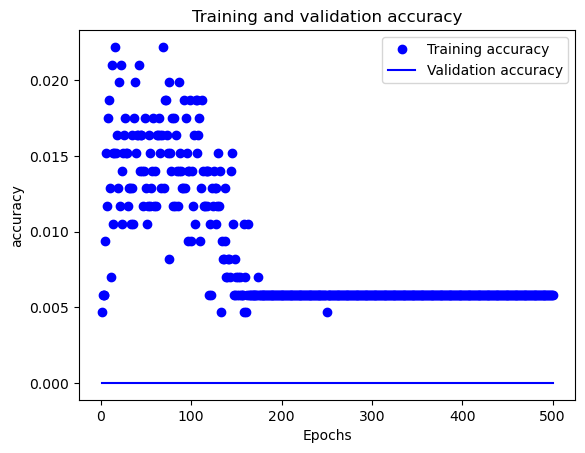

In [25]:
plot_history("loss")
plot_history("root_mean_squared_error")
plot_history("accuracy")
history_dict = history.history
RMSE_values4 = np.mean(history_dict["root_mean_squared_error"])
val_RMSE_values4 = np.mean(history_dict["val_root_mean_squared_error"])
accuracy_values4 = np.mean(history_dict['accuracy'])
val_accuracy_values4 = np.mean(history_dict['val_accuracy'])

In [26]:
ypred4 = model4.predict(X_test)

1/1 [==============================] - 0s 149ms/step


Text(0.5, 1.0, 'Actual vs. Prediction for 3 Deep Learning Methods')

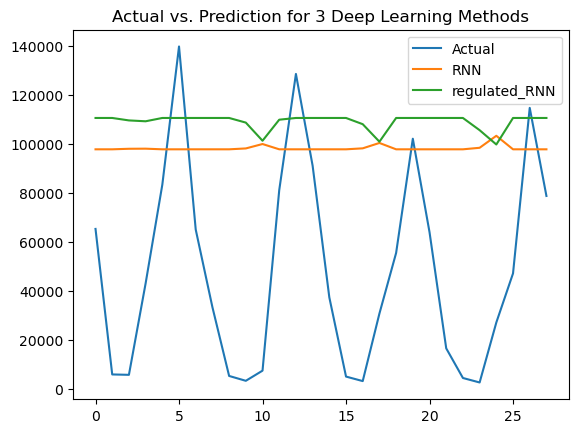

In [27]:
plt.figure()
results['regulated_RNN'] = ypred4
results['actual'].plot(label='Actual')
results['RNN'].plot(label='RNN')
results['regulated_RNN'].plot(label='regulated_RNN')
plt.legend()
plt.title('Actual vs. Prediction for 3 Deep Learning Methods')

In [28]:
evaluation = pd.DataFrame()
evaluation['RNN'] = RMSE_values,val_RMSE_values,accuracy_values
evaluation['LSTM'] = RMSE_values2,val_RMSE_values2,accuracy_values2
evaluation['GRU'] = RMSE_values3,val_RMSE_values3,accuracy_values3
evaluation['regulated_RNN'] = RMSE_values4,val_RMSE_values4,accuracy_values4
evaluation

,RNN,LSTM,GRU,regulated_RNN
0,140309.938938,141674.997000,141472.424781,142166.792187
1,66965.486039,67345.735477,68069.000531,65773.235781
2,0.016136,0.014871,0.013126,0.008161
